In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings
import os

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

from utils import simulate_onestep_campi_example_1

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [2]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
import tqdm
import argparse
import metrics

In [3]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [4]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [5]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [6]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_controller_simple_example_1_500.pt", map_location=device)

In [7]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [8]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 2.43M


In [9]:
import pickle as pkl

with open('../data/control/test_set_simple_example_1.pkl', 'rb') as f:
    test_set = pkl.load(f)

data_test = test_set['data_test']

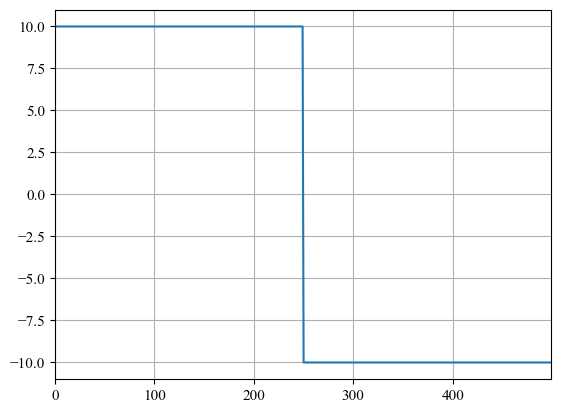

In [10]:
# reference
Ts = 0.1
t_CL = np.arange(0, 50, Ts)

r = np.zeros(t_CL.shape)
# r[t_CL < 1] = 2.7
# r[(t_CL >= 1) & (t_CL < 2)] = -2.7
# r[(t_CL >= 2) & (t_CL < 3.5)] = 5
# r[(t_CL >= 3.5) & (t_CL < 5)] = 0
r[t_CL < 25] = 10
r[(t_CL >= 25) & (t_CL < 50)] = -10
# r[(t_CL >= 5) & (t_CL < 10)] = 3.6
# r[(t_CL >= 10) & (t_CL < 15)] = 4.1
# r[(t_CL >= 15) & (t_CL < 25)] = 3.8
# r[(t_CL >= 25) & (t_CL < 35)] = 2.1
# r[(t_CL >= 35)] = 4.1

plt.plot(r)

In [11]:
from control.matlab import *

In [ ]:
n_testing = 0
H = 1000 

# e = torch.Tensor([[[]]])
# u = torch.Tensor([[[]]])


y_log = np.zeros((len(data_test),len(t_CL)))
e_log = np.zeros((len(data_test),len(t_CL)))
u_log = np.zeros((len(data_test),len(t_CL)))
u_prev_log = np.zeros((len(data_test),len(t_CL)))

Ts = 0.1; Fs = 1 / Ts
s = tf('s')
# problem data


with torch.no_grad():
    for n_testing in range(len(data_test)):
        
        print(n_testing)
        
        e = torch.Tensor([[[]]])
        e_prev = torch.Tensor([[[]]])
        u = torch.Tensor([[[]]])
        
        x_i = np.array([1e-6, 1e-6, 1e-6, 1e-6])
        y_i = x_i[0]
        u_i = 1e-6
        
        data = data_test[n_testing]
        # system
        num = [data['num_1']]
        den = [data['den_1'], data['den_2'], data['den_3']]
        P = tf(num, den)
        
        e_i = torch.Tensor([[[.0]]])
        
        for i in range(len(t_CL)):#batch_u.shape[0]): # for each system
    
            u_i_prev = torch.Tensor([[[u_i]]]) 
            e_prev_i = e_i
            e_i = torch.Tensor([[[r[i] - y_i]]])
            
            y_log[n_testing,i] = y_i
            e_log[n_testing,i] = e_i
            u_prev_log[n_testing,i] = u_i_prev
    
            e = torch.cat((e,e_i),2)
            e_prev = torch.cat((e_prev,e_prev_i),2)
            input = torch.cat((e, e_prev),2)
            u = torch.cat((u,u_i_prev),2)

            #print(e.shape)
            # e = e_i
            # u = torch.Tensor([[[u_i]]])
    
            # Controller

            if i < H:
                pred, _ = model(input.reshape(1,-1,2), u.reshape(1,-1,1))
            else:
                e_tmp = e.reshape(1,-1,1)
                u_tmp = u.reshape(1,-1,1)
                pred, _ = model(e_tmp[:,-H:,:], u_tmp[:,-H:,:])
    
            u_i = pred[:,-1,:].item()
            u_log[n_testing,i] = u_i
    
            # simulation
            y_i, _, x_i = lsim(P, u_i, np.array([0.0, Ts]), x_i[-1])
    
            y_i = y_i[-1]
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [ ]:
fig = plt.figure(figsize=(7, 5))
ax1 = plt.subplot(311)
#plt.plot(t_CL, r)
plt.plot(t_CL, r, label="$r$", c='tab:orange')
plt.plot(t_CL, y_log.T, label="$y$", c='tab:blue', alpha=1)
plt.legend(['$r$','$y$'])
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t_CL, u_log.T, c='tab:blue', alpha=1)
plt.legend(['$u$'])
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(t_CL, e_log.T, c='tab:blue', alpha=1)
plt.xlabel('$t$ [s]')
plt.legend(['$e$'])

# plt.savefig('transformer_controller.pdf')

plt.show()